## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

To help the reviewer evaluate your project, please save example images from each stage of your pipeline to the <b>output_images</b> folder and provide in your writeup a description of each image. Please also save your output video and include it with your submission.


---
## First, I'll compute the camera calibration using chessboard images

* <i>Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

 * OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder). </i>
 
### Finding corners

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
#def get_calibration():
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname) # BGR image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        #print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        """
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        plt.imshow(img)
        print("Size of image points array: ", len(imgpoints))

cv2.destroyAllWindows()
"""

ret, mtx, dist, rvecs, tvecs = \
    cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

## Apply a distortion correction to raw images.

* <i>Provide an example of a distortion-corrected image.

    * Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.</i>

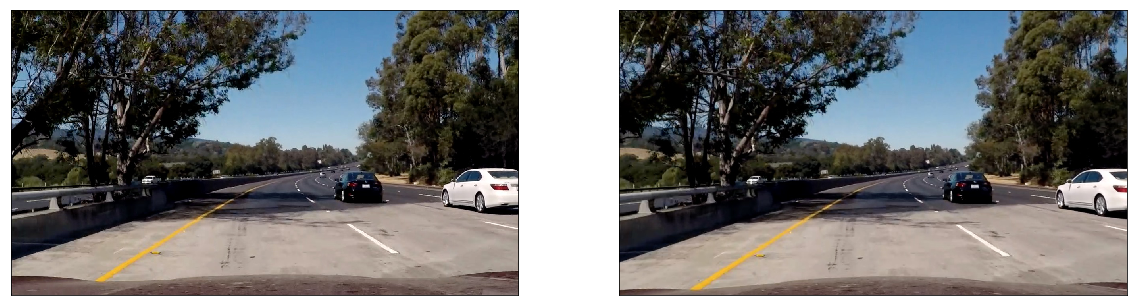

"\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(grad_binary, cmap='gray')\nax2.set_title('Thresholded x-derivative', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [3]:
def distortion_correction(img, mtx, dist):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    return undst





fname = './test_images/test5.jpg'

#fname = './camera_cal/calibration1.jpg'
image = cv2.imread(fname) # BGR image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cal_image = distortion_correction(image, mtx, dist)

new_images = []

new_images.append(image)
new_images.append(cal_image)

fig=plt.figure(figsize=(20, 20))

columns = 2
rows = 1

for i in range(1, columns*rows +1):
    img = new_images[i-1]
    fig.add_subplot(rows, columns, i)
    axes_fig = plt.imshow(img)
    axes_fig.axes.get_xaxis().set_visible(False)
    axes_fig.axes.get_yaxis().set_visible(False)
plt.show()
"""
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded x-derivative', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""
#cal_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#cv2.imwrite('./test_images/straight_lines1_undistorted_2.jpg', cal_img)


## Use color transforms, gradients, etc., to create a thresholded binary image.


* <i>Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.
    
    * A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.
    
</i>

------
### Sobel

In [4]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary



"""
#fname = './test_images/straight_lines1.jpg'
#fname = './test_images/straight_lines2.jpg'
#fname = './test_images/test1.jpg'
#fname = './test_images/test2.jpg'
#fname = './test_images/test3.jpg'
#fname = './test_images/test4.jpg'
fname = './test_images/test5.jpg'
#fname = './test_images/test6.jpg'
image = cv2.imread(fname) # BGR image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

print(image.shape[0], image.shape[1])

# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded x-derivative', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\n#fname = './test_images/straight_lines1.jpg'\n#fname = './test_images/straight_lines2.jpg'\n#fname = './test_images/test1.jpg'\n#fname = './test_images/test2.jpg'\n#fname = './test_images/test3.jpg'\n#fname = './test_images/test4.jpg'\nfname = './test_images/test5.jpg'\n#fname = './test_images/test6.jpg'\nimage = cv2.imread(fname) # BGR image\nimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) \n\nprint(image.shape[0], image.shape[1])\n\n# Run the function\ngrad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 100))\n\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(grad_binary, cmap='gray')\nax2.set_title('Thresholded x-derivative', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

### Magnitude of the gradient

In [5]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

"""
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\n# Run the function\nmag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))\n\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(mag_binary, cmap='gray')\nax2.set_title('Thresholded Magnitude', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

### Direction of the gradient

An orientation of 0 implies a vertical line and orientation of +- pi/2 implies a horizontal line

In [6]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.absolute(np.arctan(sobely, sobelx))
    #absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

"""
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\n# Run the function\ndir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))\n\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(dir_binary, cmap='gray')\nax2.set_title('Thresholded Grad. Dir.', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

### Combining gradients

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements


# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) # 0 is vertical and +-pi/2 is horizontal

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color spaces

In [7]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

"""
hls_binary = hls_select(image, thresh=(90, 255))


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\nhls_binary = hls_select(image, thresh=(90, 255))\n\n\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(hls_binary, cmap='gray')\nax2.set_title('Thresholded S', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

### Combining it all together

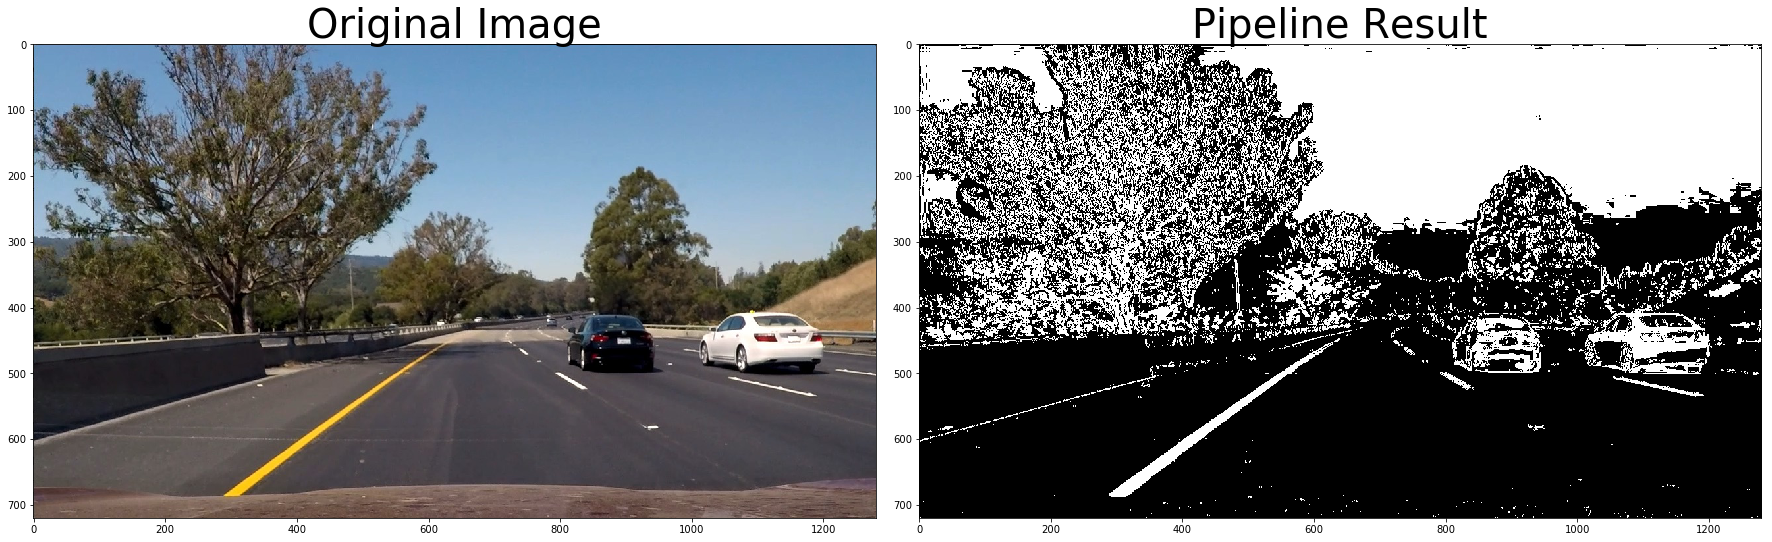

In [8]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(100, 255), v_thresh=(50, 255), sx_thresh=(20, 100)):
        
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]

    # Threshold color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    ### s thresholding ###
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    ### l thresholding ###
    l_thresh=(150, 255)

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    ### Direction thresholding ###
    direction = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/4))

    ### Grad x/y ###
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(12, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(25, 255))

    ### COMBINING ###
    # Combine the two binary thresholds
    combined_binary_1 = np.zeros_like(s_binary)
    combined_binary_2 = np.zeros_like(s_binary)
    combined_binary_3 = np.zeros_like(s_binary)
    #combined_binary_1[((s_binary == 1) | (v_binary == 1)) & (l_binary == 1)] = 1
    combined_binary_1[(s_binary == 1) | (v_binary == 1)] = 1
    combined_binary_2[(s_binary == 1) & (v_binary == 1)] = 1
    combined_binary_3[((s_binary == 1) & (v_binary == 1)) | ((gradx == 1) & (grady == 1) )] = 255
    """
    return combined_binary


#fname = './test_images/straight_lines1.jpg'
#fname = './test_images/straight_lines2.jpg'
#fname = './test_images/test1.jpg'
#fname = './test_images/test2.jpg'
#fname = './test_images/test3.jpg'
#fname = './test_images/test4.jpg'
#fname = './test_images/test5.jpg'
fname = './test_images/test6.jpg'
img = cv2.imread(fname) # BGR image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    
result = pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap = 'gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [9]:
"""
import pickle

dist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#fname = './test_images/straight_lines1.jpg'
#fname = './test_images/straight_lines2.jpg'
#fname = './test_images/test1.jpg'
#fname = './test_images/test2.jpg'
#fname = './test_images/test3.jpg'
#fname = './test_images/test4.jpg'
#fname = './test_images/test5.jpg'
fname = './test_images/test6.jpg'
image = cv2.imread(fname) # BGR image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    

undist = distortion_correction(image, mtx, dist)

binary = pipeline(undist, s_thresh=(120, 255), sx_thresh=(20, 100))

warped, M, Minv = corners_unwarp(binary)

warped_poly, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(warped)

print(left_fit, right_fit)


### v thresholding ###
#v_thresh=(220, 255)
v_thresh=(50, 255)

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
v_channel = hsv[:,:,2]

# Threshold color channel
v_binary = np.zeros_like(v_channel)
v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

### s thresholding ###
#s_thresh=(170, 255)
s_thresh=(100, 255)

# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

### l thresholding ###
l_thresh=(150, 255)

l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

### Direction thresholding ###
direction = dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/4))

### Grad x/y ###
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(12, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(25, 255))

### COMBINING ###
# Combine the two binary thresholds
combined_binary_1 = np.zeros_like(s_binary)
combined_binary_2 = np.zeros_like(s_binary)
combined_binary_3 = np.zeros_like(s_binary)
#combined_binary_1[((s_binary == 1) | (v_binary == 1)) & (l_binary == 1)] = 1
combined_binary_1[(s_binary == 1) | (v_binary == 1)] = 1
combined_binary_2[(s_binary == 1) & (v_binary == 1)] = 1
combined_binary_3[((s_binary == 1) & (v_binary == 1)) | ((gradx == 1) & (grady == 1) )] = 255

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary_3, cmap = 'gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_binary_2, cmap = 'gray')
ax2.set_title('Warped result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

'\nimport pickle\n\ndist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", "rb"))\nmtx = dist_pickle["mtx"]\ndist = dist_pickle["dist"]\n\n#fname = \'./test_images/straight_lines1.jpg\'\n#fname = \'./test_images/straight_lines2.jpg\'\n#fname = \'./test_images/test1.jpg\'\n#fname = \'./test_images/test2.jpg\'\n#fname = \'./test_images/test3.jpg\'\n#fname = \'./test_images/test4.jpg\'\n#fname = \'./test_images/test5.jpg\'\nfname = \'./test_images/test6.jpg\'\nimage = cv2.imread(fname) # BGR image\nimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    \n\nundist = distortion_correction(image, mtx, dist)\n\nbinary = pipeline(undist, s_thresh=(120, 255), sx_thresh=(20, 100))\n\nwarped, M, Minv = corners_unwarp(binary)\n\nwarped_poly, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(warped)\n\nprint(left_fit, right_fit)\n\n\n### v thresholding ###\n#v_thresh=(220, 255)\nv_thresh=(50, 255)\n\nhsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)\nv_channel = hsv[:,:,2]\n\n# 

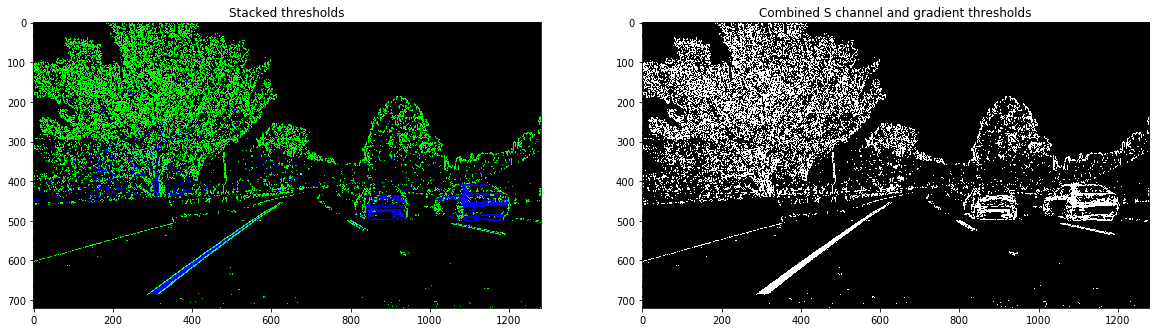

In [10]:
# Take 2

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Apply a perspective transform to rectify binary image ("birds-eye view").

* <i> Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

    * OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.</i>

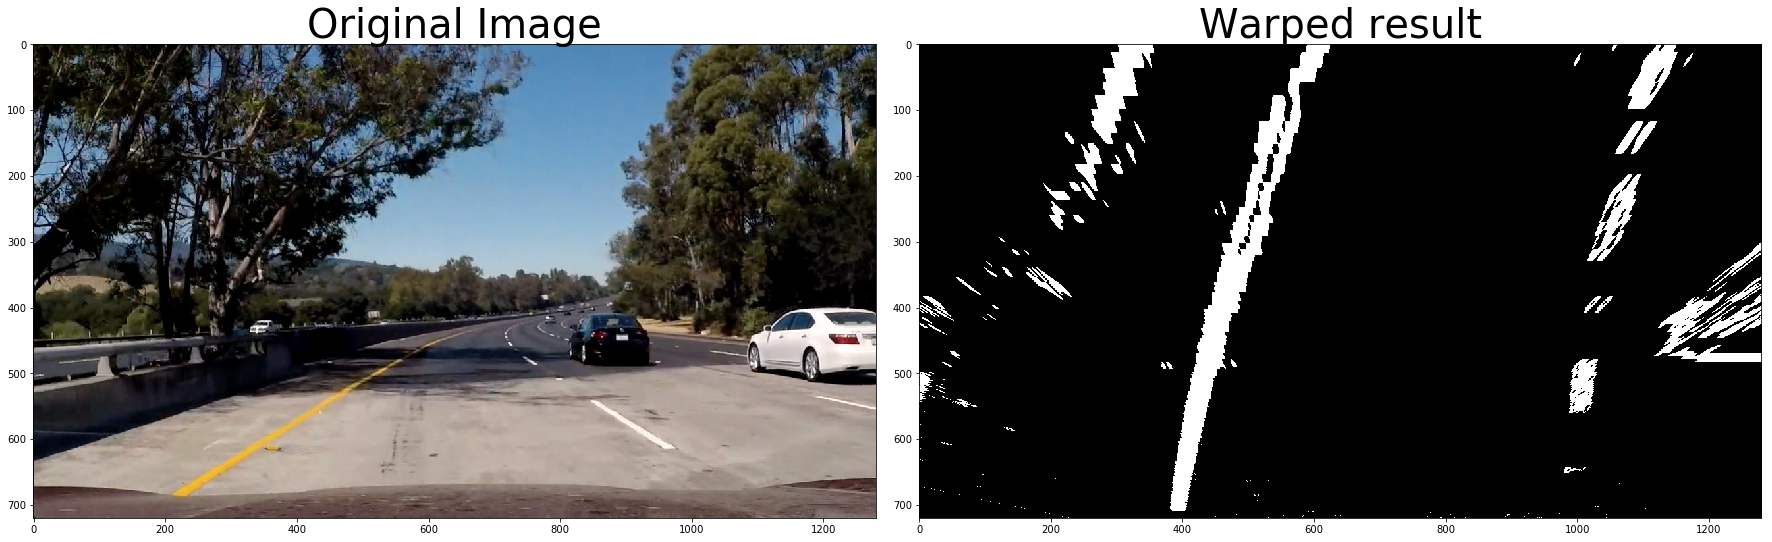

In [11]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients

# How I did it chapter

def corners_unwarp(img):
    # Use the OpenCV undistort() function to remove distortion
    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert image to grayscale
    if len(img.shape) < 3:
    #print(img.shape)
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
    #print(gray.shape)
 
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0]) #0 - 720 and 1 - 1280

    UL_src = [588, 450]
    UR_src = [692, 450]
    DR_src = [1120, 719]
    DL_src = [158, 719]

    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([UL_src, UR_src, DR_src, DL_src]) 
    
    UL_dst = [328, 0]
    UR_dst = [950, 0]
    DR_dst = [950, 719]
    DL_dst = [328, 719]
    
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([UL_dst, UR_dst, DR_dst, DL_dst])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


#corrected = distortion_correction(img, mtx, dist)

transformed, M, Minv = corners_unwarp(result)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(transformed, cmap = 'gray')
ax2.set_title('Warped result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Detect lane pixels and fit to find the lane boundary.

* <i> Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

    * Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.</i>

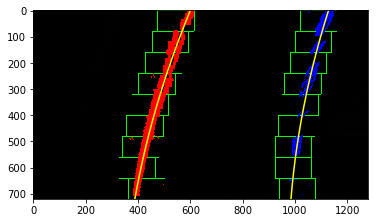

In [12]:
# with "test6.jpg" one dashed line fitted in the rectangle in y direction and there are 9 rectangles, so 9 * 3
ym_per_pix = 27 / 720
# The USA lane lines should be 3.7 m apart and on the same image the lane lines are @ 400 ja 1000
xm_per_pix = 3.7 / 600

# Load our image
#binary_warped = mpimg.imread('warped_example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    # ToDo: Try 1/3 or 1/4 of a image to position the start a little bit better
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 70

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Polynomial for real world radius calculation
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr

### TAKE 2 WITH SEARCH FROM PRIOR ###

# Load our image - this should be a new frame since last time!
#binary_warped = mpimg.imread('warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Polynomial for real world radius calculation
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        status = 1
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty 
        status = 0
    
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, status, left_fit_cr, right_fit_cr

def search_around_poly(binary_warped, left_fit, right_fit, left_fitx, right_fitx, ploty):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 15

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx_temp, right_fitx_temp, ploty_temp, left_fit_temp, right_fit_temp, status, left_fit_cr, right_fit_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    lines_distance =  right_fitx_temp[-1] - left_fitx_temp[-1]
    
    if status == 1 and lines_distance < 700 and lines_distance > 500:
        left_fitx = left_fitx_temp 
        right_fitx = right_fitx_temp 
        ploty = ploty_temp 
        left_fit = left_fit_temp 
        right_fit = right_fit_temp
    """
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    """
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    """
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    """
    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result = search_around_poly(binary_warped)

# View your output
#plt.imshow(result)

poly = fit_polynomial(transformed)

## Determine the curvature of the lane and vehicle position with respect to center.

* <i> Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

    * Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.</i>

In [16]:
# with "test6.jpg" one dashed line fitted in 1 rectangles in y direction and there are 9 rectangles, so 9 * 3
ym_per_pix = 27 / 720
# The USA lane lines should be 3.7 m apart and on the same image the lane lines are @ 400 ja 1000
xm_per_pix = 3.7 / 600

def measure_curvature_real(ploty, left_fit, right_fit):
    """
    Calculates the curvature of polynomial functions in pixels.
    """
    
    # Define y-value where we want radius of curvature
    # We'll choose the y-value ~70% from the top of the image
    #y_eval = 500
    
    y_value = 650
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2 * left_fit[0] * ploty[y_value] * ym_per_pix + left_fit[1])**2)**(3/2)) / abs(2 * left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2 * right_fit[0] * ploty[y_value] * ym_per_pix + right_fit[1])**2)**(3/2)) / abs(2 * right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def measure_offset_real(left_fitx, right_fitx):
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    
    car_pos = (left_fitx[-1] + right_fitx[-1]) / 2
    
    
    # ToDo: measure the offset as the polynomial gives in the y max position 
    # and find the lines midpoint offset from the picture midpoint
    offset = (1280 / 2 - car_pos) * xm_per_pix
    
    return offset



## Warp the detected lane boundaries back onto the original image.

* <i> Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

    * The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.</i>

"""Once you have a good measurement of the line positions in warped space, it's time to project your 
measurement back down onto the road! Let's suppose, as in the previous example, you have a warped 
binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, 
left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project 
those lines onto the original image as follows:"""

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

* <i> Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

    * The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.</i>


## Line() class to keep track of parameters
<i> After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. In this case, however, you're going to keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections. To do this, it's useful to define a Line() class to keep track of all the interesting parameters you measure from frame to frame. Here's an example: </i>

## Sanity checks
<i> Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:
* Checking that they have similar curvature 
* Checking that they are separated by approximately the right distance horizontally
* Checking that they are roughly parallel </i>

## Picture pipeline coming together

In [14]:
import pickle

dist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#fname = './test_images/straight_lines1.jpg'
#fname = './test_images/straight_lines2.jpg'
#fname = './test_images/test1.jpg'
#fname = './test_images/test2.jpg'
#fname = './test_images/test3.jpg'
#fname = './test_images/test4.jpg'
#fname = './test_images/test5.jpg'
#fname = './test_images/test6.jpg'
#image = cv2.imread(fname) # BGR image


class Line():
    def __init__(self, my_mtx, my_dist, Mysmooth_factor = 2):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
        #My added stuff
        self.left_fit = 0
        self.right_fit = 0
        self.left_fitx = 0
        self.right_fitx = 0
        self.ploty = 0
        self.initial_lines_found = 0
        
        self.mtx = my_mtx
        self.dist = my_dist
        
        self.recent_left_fit = []
        self.recent_right_fit = []
        
        self.recent_left_fitx = []
        self.recent_right_fitx = []
        
        self.smooth_factor = Mysmooth_factor
    


    def process_image(self, image):
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        undist = distortion_correction(image, self.mtx, self.dist)

        result = pipeline(undist, s_thresh=(100, 255), sx_thresh=(20, 100))

        warped, M, Minv = corners_unwarp(result)

        #result = find_lane_pixels(bird_view)
        if self.initial_lines_found == 0:
            warped, left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr = fit_polynomial(warped)
            self.initial_lines_found = 1
        else:
            warped, left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr = search_around_poly(warped, self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty)

        self.recent_left_fitx.append(left_fitx)    
        self.recent_right_fitx.append(right_fitx)    
            
            
        result = image

        temp = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(temp).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        avg_left_fitx = np.average(self.recent_left_fitx[-self.smooth_factor:], axis = 0)
        avg_right_fitx = np.average(self.recent_right_fitx[-self.smooth_factor:], axis = 0)
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([avg_left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([avg_right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        print(color_warp.shape)

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        radius = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
        offset = measure_offset_real(left_fitx, right_fitx)
        #print("Radius: ", radius)
        cv2.putText(result, 'Radius: ' + str(int(np.average(radius))) + ' m',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(result, 'Offset: ' + str(round(np.average(offset),3)) + ' m',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

        #plt.imshow(result)

        self.left_fit = left_fit
        self.right_fit = right_fit
        
        self.left_fitx = left_fitx
        self.right_fitx = right_fitx
        
        self.ploty = ploty
        
        return result


"""
#

#fname = './test_images/straight_lines1.jpg'
#fname = './test_images/straight_lines2.jpg'
#fname = './test_images/test1.jpg'
#fname = './test_images/test2.jpg'
#fname = './test_images/test3.jpg'
#fname = './test_images/test4.jpg'
fname = './test_images/test5.jpg'
#fname = './test_images/test6.jpg'
image = cv2.imread(fname) # BGR image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

lines2 = Line(mtx, dist)

result = lines2.process_image(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap = 'gray')
ax2.set_title('Final', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""

"\n#\n\n#fname = './test_images/straight_lines1.jpg'\n#fname = './test_images/straight_lines2.jpg'\n#fname = './test_images/test1.jpg'\n#fname = './test_images/test2.jpg'\n#fname = './test_images/test3.jpg'\n#fname = './test_images/test4.jpg'\nfname = './test_images/test5.jpg'\n#fname = './test_images/test6.jpg'\nimage = cv2.imread(fname) # BGR image\nimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) \n\nlines2 = Line(mtx, dist)\n\nresult = lines2.process_image(image)\n\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\n\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=40)\n\nax2.imshow(result, cmap = 'gray')\nax2.set_title('Final', fontsize=40)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

### Useful code snipets
np.average(array_to_avg[-nr_of_last_measurements:], axis = 0)

### Class call
left_line = Line()

left_line.function()

## Movie time

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

dist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

start_second = 0
end_second = 5

left_fit = 0
right_fit = 0

# Output file name
output_video = './project_video_output.mp4'

# Input file name
input_video = VideoFileClip("./project_video.mp4")#.subclip(start_second,end_second)

lines = Line(mtx, dist)

# Processing
output_video_clip = input_video.fl_image(lines.process_image) #NOTE: this function expects color images!!
%time output_video_clip.write_videofile(output_video, audio=False)

(720, 1280, 3)
[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(720, 1280, 3)


  0%|          | 1/1261 [00:00<02:57,  7.11it/s]

(720, 1280, 3)


  0%|          | 2/1261 [00:00<02:55,  7.19it/s]

(720, 1280, 3)


  0%|          | 3/1261 [00:00<02:52,  7.28it/s]

(720, 1280, 3)


  0%|          | 4/1261 [00:00<02:47,  7.48it/s]

(720, 1280, 3)


  0%|          | 5/1261 [00:00<02:47,  7.52it/s]

(720, 1280, 3)


  0%|          | 6/1261 [00:00<02:47,  7.51it/s]

(720, 1280, 3)


  1%|          | 7/1261 [00:00<02:46,  7.53it/s]

(720, 1280, 3)


  1%|          | 8/1261 [00:01<02:46,  7.53it/s]

(720, 1280, 3)


  1%|          | 9/1261 [00:01<02:48,  7.43it/s]

(720, 1280, 3)


  1%|          | 10/1261 [00:01<02:49,  7.38it/s]

(720, 1280, 3)


  1%|          | 11/1261 [00:01<02:49,  7.38it/s]

(720, 1280, 3)


  1%|          | 12/1261 [00:01<02:49,  7.39it/s]

(720, 1280, 3)


  1%|          | 13/1261 [00:01<02:49,  7.38it/s]

(720, 1280, 3)


  1%|          | 14/1261 [00:01<02:47,  7.43it/s]

(720, 1280, 3)


  1%|          | 15/1261 [00:02<02:48,  7.42it/s]

(720, 1280, 3)


  1%|▏         | 16/1261 [00:02<02:47,  7.45it/s]

(720, 1280, 3)


  1%|▏         | 17/1261 [00:02<02:46,  7.46it/s]

(720, 1280, 3)


  1%|▏         | 18/1261 [00:02<02:46,  7.48it/s]

(720, 1280, 3)


  2%|▏         | 19/1261 [00:02<02:46,  7.47it/s]

(720, 1280, 3)


  2%|▏         | 20/1261 [00:02<02:46,  7.46it/s]

(720, 1280, 3)


  2%|▏         | 21/1261 [00:02<02:45,  7.48it/s]

(720, 1280, 3)


  2%|▏         | 22/1261 [00:02<02:45,  7.50it/s]

(720, 1280, 3)


  2%|▏         | 23/1261 [00:03<02:44,  7.51it/s]

(720, 1280, 3)


  2%|▏         | 24/1261 [00:03<02:44,  7.53it/s]

(720, 1280, 3)


  2%|▏         | 25/1261 [00:03<02:44,  7.53it/s]

(720, 1280, 3)


  2%|▏         | 26/1261 [00:03<02:44,  7.53it/s]

(720, 1280, 3)


  2%|▏         | 27/1261 [00:03<02:44,  7.51it/s]

(720, 1280, 3)


  2%|▏         | 28/1261 [00:03<02:43,  7.55it/s]

(720, 1280, 3)


  2%|▏         | 29/1261 [00:03<02:42,  7.56it/s]

(720, 1280, 3)


  2%|▏         | 30/1261 [00:03<02:42,  7.58it/s]

(720, 1280, 3)


  2%|▏         | 31/1261 [00:04<02:42,  7.58it/s]

(720, 1280, 3)


  3%|▎         | 32/1261 [00:04<02:42,  7.59it/s]

(720, 1280, 3)


  3%|▎         | 33/1261 [00:04<02:41,  7.59it/s]

(720, 1280, 3)


  3%|▎         | 34/1261 [00:04<02:41,  7.59it/s]